In [320]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pl
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde, skew, pearsonr
from sklearn.neighbors import KernelDensity
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN

In [321]:
def mann_whitney_u_test(x, y, alternative="less"):
    u, p = mannwhitneyu(x, y, alternative=alternative)
    nx = len(x)
    ny = len(y)
    mu_u = (nx * ny) / 2
    sigma_u = np.sqrt(nx * ny * (nx + ny + 1) / 12)
    z = (u - mu_u) / sigma_u
    n = len(x) + len(y)
    r = z / np.sqrt(n)
    return u, p, r

# Load results

In [322]:
def load_data(name, protected):
    if protected:
        path = "protected/" + name
    else:
        path = "unprotected/" + name
    results = dict()
    results["K"] = np.load("results/" + path + "/K.npy")
    
    results["nr_neighbors_userknn_full"] = np.load("results/" + path + "/nr_neighbors_userknn_full.npy")
    results["nr_neighbors_userknn"] = np.load("results/" + path + "/nr_neighbors_userknn.npy")
    results["nr_neighbors_pop"] = np.load("results/" + path + "/nr_neighbors_pop.npy")
    results["nr_neighbors_gain"] = np.load("results/" + path + "/nr_neighbors_gain.npy")
    results["nr_neighbors_userknn_reuse"] = np.load("results/" + path + "/nr_neighbors_userknn_reuse.npy")
    results["nr_neighbors_pop_reuse"] = np.load("results/" + path + "/nr_neighbors_pop_reuse.npy")
    results["nr_neighbors_gain_reuse"] = np.load("results/" + path + "/nr_neighbors_gain_reuse.npy")
    results["nr_neighbors_userknn_no"] = np.load("results/" + path + "/nr_neighbors_userknn_no.npy")
    
    results["mae_all_userknn_full"] = np.load("results/" + path + "/mae_all_userknn_full.npy")
    results["mae_all_userknn"] = np.load("results/" + path + "/mae_all_userknn.npy")
    results["mae_all_pop"] = np.load("results/" + path + "/mae_all_pop.npy")
    results["mae_all_gain"] = np.load("results/" + path + "/mae_all_gain.npy")
    results["mae_all_userknn_reuse"] = np.load("results/" + path + "/mae_all_userknn_reuse.npy")
    results["mae_all_pop_reuse"] = np.load("results/" + path + "/mae_all_pop_reuse.npy")
    results["mae_all_gain_reuse"] = np.load("results/" + path + "/mae_all_gain_reuse.npy")
    results["mae_all_userknn_no"] = np.load("results/" + path + "/mae_all_userknn_no.npy")
    
    results["mae_below_userknn_full"] = np.load("results/" + path + "/mae_below_userknn_full.npy")
    results["mae_below_userknn"] = np.load("results/" + path + "/mae_below_userknn.npy")
    results["mae_below_pop"] = np.load("results/" + path + "/mae_below_pop.npy")
    results["mae_below_gain"] = np.load("results/" + path + "/mae_below_gain.npy")
    results["mae_below_userknn_reuse"] = np.load("results/" + path + "/mae_below_userknn_reuse.npy")
    results["mae_below_pop_reuse"] = np.load("results/" + path + "/mae_below_pop_reuse.npy")
    results["mae_below_gain_reuse"] = np.load("results/" + path + "/mae_below_gain_reuse.npy")
    results["mae_below_userknn_no"] = np.load("results/" + path + "/mae_below_userknn_no.npy")
    
    results["mae_above_userknn_full"] = np.load("results/" + path + "/mae_above_userknn_full.npy")
    results["mae_above_userknn"] = np.load("results/" + path + "/mae_above_userknn.npy")
    results["mae_above_pop"] = np.load("results/" + path + "/mae_above_pop.npy")
    results["mae_above_gain"] = np.load("results/" + path + "/mae_above_gain.npy")
    results["mae_above_userknn_reuse"] = np.load("results/" + path + "/mae_above_userknn_reuse.npy")
    results["mae_above_pop_reuse"] = np.load("results/" + path + "/mae_above_pop_reuse.npy")
    results["mae_above_gain_reuse"] = np.load("results/" + path + "/mae_above_gain_reuse.npy")
    results["mae_above_userknn_no"] = np.load("results/" + path + "/mae_above_userknn_no.npy")
    
    results["pr_all_userknn_full"] = np.load("results/" + path + "/pr_all_userknn_full.npy")
    results["pr_all_userknn"] = np.load("results/" + path + "/pr_all_userknn.npy")
    results["pr_all_pop"] = np.load("results/" + path + "/pr_all_pop.npy")
    results["pr_all_gain"] = np.load("results/" + path + "/pr_all_gain.npy")
    results["pr_all_userknn_reuse"] = np.load("results/" + path + "/pr_all_userknn_reuse.npy")
    results["pr_all_pop_reuse"] = np.load("results/" + path + "/pr_all_pop_reuse.npy")
    results["pr_all_gain_reuse"] = np.load("results/" + path + "/pr_all_gain_reuse.npy")
    results["pr_all_userknn_no"] = np.load("results/" + path + "/pr_all_userknn_no.npy")
    
    results["pr_below_userknn_full"] = np.load("results/" + path + "/pr_below_userknn_full.npy")
    results["pr_below_userknn"] = np.load("results/" + path + "/pr_below_userknn.npy")
    results["pr_below_pop"] = np.load("results/" + path + "/pr_below_pop.npy")
    results["pr_below_gain"] = np.load("results/" + path + "/pr_below_gain.npy")
    results["pr_below_userknn_reuse"] = np.load("results/" + path + "/pr_below_userknn_reuse.npy")
    results["pr_below_pop_reuse"] = np.load("results/" + path + "/pr_below_pop_reuse.npy")
    results["pr_below_gain_reuse"] = np.load("results/" + path + "/pr_below_gain_reuse.npy")
    results["pr_below_userknn_no"] = np.load("results/" + path + "/pr_below_userknn_no.npy")
    
    results["pr_above_userknn_full"] = np.load("results/" + path + "/pr_above_userknn_full.npy")
    results["pr_above_userknn"] = np.load("results/" + path + "/pr_above_userknn.npy")
    results["pr_above_pop"] = np.load("results/" + path + "/pr_above_pop.npy")
    results["pr_above_gain"] = np.load("results/" + path + "/pr_above_gain.npy")
    results["pr_above_userknn_reuse"] = np.load("results/" + path + "/pr_above_userknn_reuse.npy")
    results["pr_above_pop_reuse"] = np.load("results/" + path + "/pr_above_pop_reuse.npy")
    results["pr_above_gain_reuse"] = np.load("results/" + path + "/pr_above_gain_reuse.npy")
    results["pr_above_userknn_no"] = np.load("results/" + path + "/pr_above_userknn_no.npy")
    
    results["secures_userknn_full"] = np.load("results/" + path + "/secures_userknn_full.npy")
    results["secures_userknn"] = np.load("results/" + path + "/secures_userknn.npy")
    results["secures_pop"] = np.load("results/" + path + "/secures_pop.npy")
    results["secures_gain"] = np.load("results/" + path + "/secures_gain.npy")
    results["secures_userknn_reuse"] = np.load("results/" + path + "/secures_userknn_reuse.npy")
    results["secures_pop_reuse"] = np.load("results/" + path + "/secures_pop_reuse.npy")
    results["secures_gain_reuse"] = np.load("results/" + path + "/secures_gain_reuse.npy")
    results["secures_userknn_no"] = np.load("results/" + path + "/secures_userknn_no.npy")
    
    results["vulnerables_userknn_full"] = np.load("results/" + path + "/vulnerables_userknn_full.npy")
    results["vulnerables_userknn"] = np.load("results/" + path + "/vulnerables_userknn.npy")
    results["vulnerables_pop"] = np.load("results/" + path + "/vulnerables_pop.npy")
    results["vulnerables_gain"] = np.load("results/" + path + "/vulnerables_gain.npy")
    results["vulnerables_userknn_reuse"] = np.load("results/" + path + "/vulnerables_userknn_reuse.npy")
    results["vulnerables_pop_reuse"] = np.load("results/" + path + "/vulnerables_pop_reuse.npy")
    results["vulnerables_gain_reuse"] = np.load("results/" + path + "/vulnerables_gain_reuse.npy")
    results["vulnerables_userknn_no"] = np.load("results/" + path + "/vulnerables_userknn_no.npy")
    
    results["nq_all_userknn_full"] = np.load("results/" + path + "/nq_all_userknn_full.npy")
    results["nq_all_userknn_no"] = np.load("results/" + path + "/nq_all_userknn_no.npy")
    results["nq_all_userknn"] = np.load("results/" + path + "/nq_all_userknn.npy")
    results["nq_all_pop"] = np.load("results/" + path + "/nq_all_pop.npy")
    results["nq_all_gain"] = np.load("results/" + path + "/nq_all_gain.npy")
    results["nq_all_userknn_reuse"] = np.load("results/" + path + "/nq_all_userknn_reuse.npy")
    results["nq_all_pop_reuse"] = np.load("results/" + path + "/nq_all_pop_reuse.npy")
    results["nq_all_gain_reuse"] = np.load("results/" + path + "/nq_all_gain_reuse.npy")
    
    results["nq_below_userknn_full"] = np.load("results/" + path + "/nq_below_userknn_full.npy")
    results["nq_below_userknn_no"] = np.load("results/" + path + "/nq_below_userknn_no.npy")
    results["nq_below_userknn"] = np.load("results/" + path + "/nq_below_userknn.npy")
    results["nq_below_pop"] = np.load("results/" + path + "/nq_below_pop.npy")
    results["nq_below_gain"] = np.load("results/" + path + "/nq_below_gain.npy")
    results["nq_below_userknn_reuse"] = np.load("results/" + path + "/nq_below_userknn_reuse.npy")
    results["nq_below_pop_reuse"] = np.load("results/" + path + "/nq_below_pop_reuse.npy")
    results["nq_below_gain_reuse"] = np.load("results/" + path + "/nq_below_gain_reuse.npy")
    
    results["nq_above_userknn_full"] = np.load("results/" + path + "/nq_above_userknn_full.npy")
    results["nq_above_userknn_no"] = np.load("results/" + path + "/nq_above_userknn_no.npy")
    results["nq_above_userknn"] = np.load("results/" + path + "/nq_above_userknn.npy")
    results["nq_above_pop"] = np.load("results/" + path + "/nq_above_pop.npy")
    results["nq_above_gain"] = np.load("results/" + path + "/nq_above_gain.npy")
    results["nq_above_userknn_reuse"] = np.load("results/" + path + "/nq_above_userknn_reuse.npy")
    results["nq_above_pop_reuse"] = np.load("results/" + path + "/nq_above_pop_reuse.npy")
    results["nq_above_gain_reuse"] = np.load("results/" + path + "/nq_above_gain_reuse.npy")
    
    if protected:
        results["thresholds"] = np.load("results/" + path + "/thresholds.npy")
        results["nr_noisy_ratings_userknn_full"] = np.load("results/" + path + "/nr_noisy_ratings_userknn_full.npy")
        results["nr_noisy_ratings_userknn"] = np.load("results/" + path + "/nr_noisy_ratings_userknn.npy")
        results["nr_noisy_ratings_pop"] = np.load("results/" + path + "/nr_noisy_ratings_pop.npy")
        results["nr_noisy_ratings_gain"] = np.load("results/" + path + "/nr_noisy_ratings_gain.npy")
        results["nr_noisy_ratings_userknn_reuse"] = np.load("results/" + path + "/nr_noisy_ratings_userknn_reuse.npy")
        results["nr_noisy_ratings_pop_reuse"] = np.load("results/" + path + "/nr_noisy_ratings_pop_reuse.npy")
        results["nr_noisy_ratings_gain_reuse"] = np.load("results/" + path + "/nr_noisy_ratings_gain_reuse.npy")
        results["nr_noisy_ratings_userknn_no"] = np.load("results/" + path + "/nr_noisy_ratings_userknn_no.npy")
    
    return results

# P1: No differential privacy

In [323]:
%matplotlib inline

In [331]:
%matplotlib qt

## Neighborhood Growth

In [333]:
k_idx = 1

ml1m_results = load_data(name="ml-1m", protected=False)
ciao_results = load_data(name="ciao", protected=False)
douban_results = load_data(name="douban", protected=False)
gr_results = load_data(name="goodreads", protected=False)
lfm_results = load_data(name="lfm", protected=False)

def plot_q_nrneighbors(ax, results): 
    ax.plot(range(100), results["nr_neighbors_userknn"][k_idx][:100], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(range(100), results["nr_neighbors_pop"][k_idx][:100], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(range(100), results["nr_neighbors_gain"][k_idx][:100], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(range(100), results["nr_neighbors_userknn_reuse"][k_idx][:100], color="C0", linestyle="solid")
    ax.plot(range(100), results["nr_neighbors_pop_reuse"][k_idx][:100], color="C1", linestyle="solid")
    ax.plot(range(100), results["nr_neighbors_gain_reuse"][k_idx][:100], color="C2", linestyle="solid")

fig, axes = plt.subplots(1, 5, figsize=(12, 4), sharex=False)
plot_q_nrneighbors(axes[0], ml1m_results)
plot_q_nrneighbors(axes[1], douban_results)
plot_q_nrneighbors(axes[2], lfm_results)
plot_q_nrneighbors(axes[3], ciao_results)
plot_q_nrneighbors(axes[4], gr_results)


axes[0].set_ylabel("Size of neighborhood")
axes[0].set_xlabel("Nr. of queries")
axes[1].set_xlabel("Nr. of queries")
axes[2].set_xlabel("Nr. of queries")
axes[3].set_xlabel("Nr. of queries")
axes[4].set_xlabel("Nr. of queries")
axes[0].set_title("MovieLens 1M")
axes[1].set_title("Douban")
axes[2].set_title("LFM")
axes[3].set_title("Ciao")
axes[4].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

## Accuracy

In [366]:
gr_results = load_data(name="goodreads", protected=False)
gr_results["mae_all_userknn"], gr_results["mae_all_pop"]

(array([0.82004345, 0.80374819, 0.79836228, 0.79575709, 0.79427563,
        0.79335159]),
 array([0.81987409, 0.80341264, 0.79804891, 0.79551195, 0.79406063,
        0.79316249]))

In [364]:
ml1m_results = load_data(name="ml-1m", protected=False)
ciao_results = load_data(name="ciao", protected=False)
douban_results = load_data(name="douban", protected=False)
gr_results = load_data(name="goodreads", protected=False)
lfm_results = load_data(name="lfm", protected=False)

def plot_k_mae(ax, results):
    ax.plot(results["K"], results["mae_all_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["K"], results["mae_all_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["K"], results["mae_all_gain_reuse"], color="C2", linestyle="solid")

fig, axes = plt.subplots(1, 5, figsize=(13, 4), sharex=False)
plot_k_mae(axes[0], ml1m_results)
plot_k_mae(axes[1], douban_results)
plot_k_mae(axes[2], lfm_results)
plot_k_mae(axes[3], ciao_results)
plot_k_mae(axes[4], gr_results)


axes[0].set_ylabel("Mean absolute error")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[4].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 1M")
axes[1].set_title("Douban")
axes[2].set_title("LFM")
axes[3].set_title("Ciao")
axes[4].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

## Popularity Bias

In [349]:
Ks = [5, 10, 15, 20, 25, 30]

ml1m_results = load_data(name="ml-1m", protected=False)
ciao_results = load_data(name="ciao", protected=False)
douban_results = load_data(name="douban", protected=False)
gr_results = load_data(name="goodreads", protected=False)
lfm_results = load_data(name="lfm", protected=False)

def test_significance(c, item_popularity):
    labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]
    n_items = len(item_popularity)
    for method in labels:
        vs = []
        for k in range(len(Ks)):
            r1 = c["UserKNN"][k]
            z1 = 0.5 * (np.log(1 + r1) - np.log(1 - r1))

            r2 = c[method][k]
            z2 = 0.5 * (np.log(1 + r2) - np.log(1 - r2))

            N1 = N2 = n_items
            v = (z1 - z2) / np.sqrt((1 / (N1 - 3)) + (1 / (N2 - 3)))
            vs.append(v)
        for k_idx in range(len(Ks)):
            print("[%s] %f/%f" % (method, c[method][k_idx], vs[k_idx]))
        #print("[%s] %s" % (method, vs))
        print()

def plot_k_r(ax, correlations): 
    #ax.plot(Ks, correlations["DP"], color="gray", linestyle="dashed", alpha=0.75)
    #ax.plot(Ks, correlations["NoKNN"], color="gray", linestyle="solid", alpha=0.75)
    ax.plot(Ks, correlations["UserKNN"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(Ks, correlations["Popularity"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(Ks, correlations["Gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(Ks, correlations["UserKNN+Reuse"], color="C0", linestyle="solid")
    ax.plot(Ks, correlations["Popularity+Reuse"], color="C1", linestyle="solid")
    ax.plot(Ks, correlations["Gain+Reuse"], color="C2", linestyle="solid")

def get_correlation(name, Ks, item_popularity):
    def pearson(d_k):
        x, y = [], []
        for iid, freq in d_k.items():
            x.append(item_popularity[iid])
            y.append(freq)
        r, p = pearsonr(x, y)
        return r

    corr = defaultdict(list)
    for k_idx, k in enumerate(Ks):
        d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn.pkl", "rb"))
        corr["UserKNN"].append(pearson(d[k_idx]))
        d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn_reuse.pkl", "rb"))
        corr["UserKNN+Reuse"].append(pearson(d[k_idx]))
        d = pl.load(open("results/unprotected/" + name + "/item_frequency_pop.pkl", "rb"))
        corr["Popularity"].append(pearson(d[k_idx]))
        d = pl.load(open("results/unprotected/" + name + "/item_frequency_pop_reuse.pkl", "rb"))
        corr["Popularity+Reuse"].append(pearson(d[k_idx]))
        d = pl.load(open("results/unprotected/" + name + "/item_frequency_gain.pkl", "rb"))
        corr["Gain"].append(pearson(d[k_idx]))
        d = pl.load(open("results/unprotected/" + name + "/item_frequency_gain_reuse.pkl", "rb"))
        corr["Gain+Reuse"].append(pearson(d[k_idx]))
    
    return corr
    
    
#fig, axes = plt.subplots(1, 5, figsize=(12, 4), sharex=False)
print("MovieLens 1M")
df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("ml-1m", Ks, item_popularity)
#plot_k_r(axes[0], c)
test_significance(c, item_popularity)

print("Douban")
df = pd.read_csv("data/douban/douban.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("douban", Ks, item_popularity)
#plot_k_r(axes[1], c)
test_significance(c, item_popularity)

print("LFM")
df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("lfm", Ks, item_popularity)
#plot_k_r(axes[2], c)
test_significance(c, item_popularity)

print("Ciao")
df = pd.read_csv("data/ciao/ciao.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("ciao", Ks, item_popularity)
#plot_k_r(axes[3], c)
test_significance(c, item_popularity)

print("Goodreads")
df = pd.read_csv("data/goodreads/sample.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("goodreads", Ks, item_popularity)
#plot_k_r(axes[4], c)
test_significance(c, item_popularity)


"""axes[0].set_ylabel("Pearson correlation")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[4].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 1M")
axes[1].set_title("Douban")
axes[2].set_title("LFM")
axes[3].set_title("Ciao")
axes[4].set_title("Goodreads")


colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = [r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)"""

MovieLens 1M


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:68: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


[UserKNN] 0.867579/0.000000
[UserKNN] 0.841008/0.000000
[UserKNN] 0.827460/0.000000
[UserKNN] 0.818602/0.000000
[UserKNN] 0.812827/0.000000
[UserKNN] 0.808311/0.000000

[UserKNN+Reuse] 0.871869/-0.757883
[UserKNN+Reuse] 0.846415/-0.807460
[UserKNN+Reuse] 0.832824/-0.742551
[UserKNN+Reuse] 0.824743/-0.813440
[UserKNN+Reuse] 0.818840/-0.773728
[UserKNN+Reuse] 0.815636/-0.925262

[Popularity] 0.848690/3.087476
[Popularity] 0.829307/1.664983
[Popularity] 0.820384/0.948150
[Popularity] 0.815344/0.421514
[Popularity] 0.812412/0.052565
[Popularity] 0.810318/-0.250353

[Popularity+Reuse] 0.852619/2.475888
[Popularity+Reuse] 0.832914/1.163094
[Popularity+Reuse] 0.824149/0.447987
[Popularity+Reuse] 0.818714/-0.014592
[Popularity+Reuse] 0.815819/-0.382148
[Popularity+Reuse] 0.813577/-0.661872

[Gain] 0.851821/2.601315
[Gain] 0.833494/1.081519
[Gain] 0.825425/0.276299
[Gain] 0.820142/-0.201617
[Gain] 0.816953/-0.528577
[Gain] 0.814598/-0.792094

[Gain+Reuse] 0.854719/2.142669
[Gain+Reuse] 0.835206

'axes[0].set_ylabel("Pearson correlation")\naxes[0].set_xlabel("Nr. of neighbors")\naxes[1].set_xlabel("Nr. of neighbors")\naxes[2].set_xlabel("Nr. of neighbors")\naxes[3].set_xlabel("Nr. of neighbors")\naxes[4].set_xlabel("Nr. of neighbors")\naxes[0].set_title("MovieLens 1M")\naxes[1].set_title("Douban")\naxes[2].set_title("LFM")\naxes[3].set_title("Ciao")\naxes[4].set_title("Goodreads")\n\n\ncolors = [\'C0\', \'C1\', \'C2\']\nlines = []\nlabels = []\nfor c in colors:\n    lines.append(Line2D([0], [0], color=c, linestyle=\'dashed\', alpha=0.5))\n    lines.append(Line2D([0], [0], color=c, linestyle="solid"))\nlabels = [r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]\n\nfig.legend(lines, labels, ncol=3, loc=\'upper center\')\nfig.tight_layout()\nfig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)\n\nfig.align_ylabels(axes)'

# P2: With differential Privacy

In [327]:
%matplotlib inline

In [336]:
%matplotlib qt

## Privacy Risk Distribution

In [317]:
def print_results(results, method, k):
    idx = np.where(results["K"] == k)[0][0]
    n_vulnerables = np.array(results["vulnerables_" + method])[idx]
    n_secures = np.array(results["secures_" + method])[idx]
    n_users = n_secures + n_vulnerables
    avg_pr_secure = results["pr_below_" + method][idx]
    
    print("[" + method + "] Avg. PR Secure / Frac. Secure: %f / %f" % (avg_pr_secure, n_secures / n_users))
    return results["pr_below_" + method][idx]

results = load_data(name="goodreads", protected=True)
pr_userknn = print_results(results, "userknn", k=10)
pr_pop = print_results(results, "pop", k=10)
pr_gain = print_results(results, "gain", k=10)
print()
pr_userknnreuse = print_results(results, "userknn_reuse", k=10)
pr_popreuse = print_results(results, "pop_reuse", k=10)
pr_gainreuse = print_results(results, "gain_reuse", k=10)

[userknn] Avg. PR Secure / Frac. Secure: 36.628052 / 0.337724
[pop] Avg. PR Secure / Frac. Secure: 17.517139 / 0.731056
[gain] Avg. PR Secure / Frac. Secure: 25.540021 / 0.629937

[userknn_reuse] Avg. PR Secure / Frac. Secure: 37.951139 / 0.452600
[pop_reuse] Avg. PR Secure / Frac. Secure: 18.292935 / 0.726975
[gain_reuse] Avg. PR Secure / Frac. Secure: 24.281023 / 0.651312


## Accuracy

In [338]:
ml1m_results = load_data(name="ml-1m", protected=True)
ciao_results = load_data(name="ciao", protected=True)
douban_results = load_data(name="douban", protected=True)
gr_results = load_data(name="goodreads", protected=True)
lfm_results = load_data(name="lfm", protected=True)

def plot_k_mae(ax, results):
    """markers = ["o", "s", "p", "*", "+", "D"]
    
    for idx in range(len(markers)):
        ax.scatter(results["K"][idx], results["mae_all_userknn_full"][idx], color="gray", alpha=0.75, marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_userknn"][idx], color="C0", alpha=0.5, marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_pop"][idx], color="C1", alpha=0.5, marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_gain"][idx], color="C2", alpha=0.5, marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_userknn_reuse"][idx], color="C0", marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_pop_reuse"][idx], color="C1", marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_gain_reuse"][idx], color="C2", marker=markers[idx])
        ax.scatter(results["K"][idx], results["mae_all_userknn_no"][idx], color="gray", marker=markers[idx])"""
        
    ax.plot(results["K"], results["mae_all_userknn_full"], color="gray", linestyle="dashed", alpha=0.75, linewidth=1)
    ax.plot(results["K"], results["mae_all_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["K"], results["mae_all_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["K"], results["mae_all_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["K"], results["mae_all_gain_reuse"], color="C2", linestyle="solid")
    ax.plot(results["K"], results["mae_all_userknn_no"], color="gray", linestyle="solid", alpha=0.75, linewidth=1)

fig, axes = plt.subplots(1, 5, figsize=(13, 4), sharex=False)
plot_k_mae(axes[0], ml1m_results)
plot_k_mae(axes[1], douban_results)
plot_k_mae(axes[2], lfm_results)
plot_k_mae(axes[3], ciao_results)
plot_k_mae(axes[4], gr_results)


axes[0].set_ylabel("Mean absolute error")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[4].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 1M")
axes[1].set_title("Douban")
axes[2].set_title("LFM")
axes[3].set_title("Ciao")
axes[4].set_title("Goodreads")

colors = ['gray', 'C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["DP", "UserKNN", r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=4, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

## Privacy

In [339]:
ml1m_results = load_data(name="ml-1m", protected=True)
ciao_results = load_data(name="ciao", protected=True)
douban_results = load_data(name="douban", protected=True)
gr_results = load_data(name="goodreads", protected=True)
lfm_results = load_data(name="lfm", protected=True)

def plot_k_pr(axes, results):
    ax1, ax2 = axes
    
    ax1.plot(results["K"], np.log10(results["pr_all_userknn"]), color="C0", linestyle="dashed", alpha=0.5)
    ax1.plot(results["K"], np.log10(results["pr_all_pop"]), color="C1", linestyle="dashed", alpha=0.5)
    ax1.plot(results["K"], np.log10(results["pr_all_gain"]), color="C2", linestyle="dashed", alpha=0.5)
    ax1.plot(results["K"], np.log10(results["pr_all_userknn_reuse"]), color="C0", linestyle="solid")
    ax1.plot(results["K"], np.log10(results["pr_all_pop_reuse"]), color="C1", linestyle="solid")
    ax1.plot(results["K"], np.log10(results["pr_all_gain_reuse"]), color="C2", linestyle="solid")
    ax1.plot(results["K"], np.log10(results["pr_all_userknn_no"]), color="gray", linestyle="solid", alpha=0.75)
    ax2.plot(results["K"], results["pr_all_userknn_full"], color="gray", linestyle="dashed", alpha=0.75)
    
    ymax = max(np.log10(results["pr_all_userknn_no"]))
    ymin = min(np.log10(results["pr_all_pop"]))
    ax1.set_ylim(ymin-0.2, ymax)
    
    #ax1.set_ylim(3, 6.8)
    ax2.set_ylim(-0.25, 0.25)

    ax1.spines["bottom"].set_visible(False)
    ax2.spines["top"].set_visible(False)
    ax1.xaxis.tick_top()
    ax1.tick_params(labeltop=False)
    ax2.xaxis.tick_bottom()

    ticks = ax1.get_yticks()
    ax1.set_yticks(ticks[1:])
    ax2.set_yticks([0.0])
    
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax2.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

    d = .5
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=10,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)
    
fig, axes = plt.subplots(2, 5, figsize=(12, 4), gridspec_kw={"hspace": 0.05, "height_ratios": [4, 1]})
#fig.subplots_adjust(hspace=0)
ax = fig.add_subplot(111, frameon=False)
ax.set_ylabel("Log. avg. privacy risk")
ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
ax.grid(False)
plot_k_pr(axes[:, 0], ml1m_results)
plot_k_pr(axes[:, 1], douban_results)
plot_k_pr(axes[:, 2], lfm_results)
plot_k_pr(axes[:, 3], ciao_results)
plot_k_pr(axes[:, 4], gr_results)

axes[0, 0].set_title("MovieLens 1M")
axes[0, 1].set_title("Douban")
axes[0, 2].set_title("LFM")
axes[0, 3].set_title("Ciao")
axes[0, 4].set_title("Goodreads")


axes[1, 0].set_xlabel("Nr. of neighbors")
axes[1, 1].set_xlabel("Nr. of neighbors")
axes[1, 2].set_xlabel("Nr. of neighbors")
axes[1, 3].set_xlabel("Nr. of neighbors")
axes[1, 4].set_xlabel("Nr. of neighbors")

colors = ['gray', 'C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["DP", "UserKNN", r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=4, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


## Popularity Bias

In [348]:
Ks = [5, 10, 15, 20, 25, 30]

ml1m_results = load_data(name="ml-1m", protected=True)
ciao_results = load_data(name="ciao", protected=True)
douban_results = load_data(name="douban", protected=True)
gr_results = load_data(name="goodreads", protected=True)
lfm_results = load_data(name="lfm", protected=True)

def test_significance(c, item_popularity):
    labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse", "DP"]
    n_items = len(item_popularity)
    for method in labels:
        vs = []
        for k in range(len(Ks)):
            r1 = c["UserKNN"][k]
            z1 = 0.5 * (np.log(1 + r1) - np.log(1 - r1))

            r2 = c[method][k]
            z2 = 0.5 * (np.log(1 + r2) - np.log(1 - r2))

            N1 = N2 = n_items
            v = (z1 - z2) / np.sqrt((1 / (N1 - 3)) + (1 / (N2 - 3)))
            vs.append(v)
        for k_idx in range(len(Ks)):
            print("[%s] %f/%f" % (method, c[method][k_idx], vs[k_idx]))
        #print("[%s] %s" % (method, vs))
        print()

def plot_k_r(ax, correlations): 
    ax.plot(Ks, correlations["DP"], color="gray", linestyle="dashed", alpha=0.75)
    #ax.plot(Ks, correlations["NoKNN"], color="gray", linestyle="solid", alpha=0.75)
    ax.plot(Ks, correlations["UserKNN"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(Ks, correlations["Popularity"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(Ks, correlations["Gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(Ks, correlations["UserKNN+Reuse"], color="C0", linestyle="solid")
    ax.plot(Ks, correlations["Popularity+Reuse"], color="C1", linestyle="solid")
    ax.plot(Ks, correlations["Gain+Reuse"], color="C2", linestyle="solid")

def get_correlation(name, Ks, item_popularity):
    def pearson(d_k):
        x, y = [], []
        for iid, freq in d_k.items():
            x.append(item_popularity[iid])
            y.append(freq)
        r, p = pearsonr(x, y)
        return r

    corr = defaultdict(list)
    for k_idx, k in enumerate(Ks):
        #d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn_no.pkl", "rb"))
        #corr["NoKNN"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_userknn_full.pkl", "rb"))
        corr["DP"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_userknn.pkl", "rb"))
        corr["UserKNN"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_userknn_reuse.pkl", "rb"))
        corr["UserKNN+Reuse"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_pop.pkl", "rb"))
        corr["Popularity"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_pop_reuse.pkl", "rb"))
        corr["Popularity+Reuse"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_gain.pkl", "rb"))
        corr["Gain"].append(pearson(d[k_idx]))
        d = pl.load(open("results/protected/" + name + "/item_frequency_gain_reuse.pkl", "rb"))
        corr["Gain+Reuse"].append(pearson(d[k_idx]))
    
    return corr
    
    
#fig, axes = plt.subplots(1, 5, figsize=(12, 4), sharex=False)
print("MovieLens 1M")
df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("ml-1m", Ks, item_popularity)
#plot_k_r(axes[0], c)
test_significance(c, item_popularity)

print("Douban")
df = pd.read_csv("data/douban/douban.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("douban", Ks, item_popularity)
#plot_k_r(axes[1], c)
test_significance(c, item_popularity)

print("LFM")
df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("lfm", Ks, item_popularity)
#plot_k_r(axes[2], c)
test_significance(c, item_popularity)

print("Ciao")
df = pd.read_csv("data/ciao/ciao.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("ciao", Ks, item_popularity)
#plot_k_r(axes[3], c)
test_significance(c, item_popularity)

print("Goodreads")
df = pd.read_csv("data/goodreads/sample.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size()
c = get_correlation("goodreads", Ks, item_popularity)
#plot_k_r(axes[4], c)
test_significance(c, item_popularity)


"""axes[0].set_ylabel("Pearson correlation")
axes[0].set_xlabel("Nr. of neighbors")
axes[1].set_xlabel("Nr. of neighbors")
axes[2].set_xlabel("Nr. of neighbors")
axes[3].set_xlabel("Nr. of neighbors")
axes[4].set_xlabel("Nr. of neighbors")
axes[0].set_title("MovieLens 1M")
axes[1].set_title("Douban")
axes[2].set_title("LFM")
axes[3].set_title("Ciao")
axes[4].set_title("Goodreads")


colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = [r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)"""

MovieLens 1M


C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:72: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


[UserKNN] 0.891298/0.000000
[UserKNN] 0.874101/0.000000
[UserKNN] 0.862859/0.000000
[UserKNN] 0.854468/0.000000
[UserKNN] 0.847795/0.000000
[UserKNN] 0.842550/0.000000

[UserKNN+Reuse] 0.889723/0.327519
[UserKNN+Reuse] 0.874555/-0.082914
[UserKNN+Reuse] 0.864462/-0.271589
[UserKNN+Reuse] 0.856789/-0.372804
[UserKNN+Reuse] 0.849800/-0.308545
[UserKNN+Reuse] 0.845357/-0.419688

[Popularity] 0.887289/0.824965
[Popularity] 0.869562/0.814273
[Popularity] 0.857419/0.899800
[Popularity] 0.849545/0.772946
[Popularity] 0.843367/0.668635
[Popularity] 0.837880/0.683558

[Popularity+Reuse] 0.888592/0.559942
[Popularity+Reuse] 0.870443/0.658301
[Popularity+Reuse] 0.859371/0.580642
[Popularity+Reuse] 0.850762/0.584133
[Popularity+Reuse] 0.844661/0.475118
[Popularity+Reuse] 0.840331/0.327127

[Gain] 0.890916/0.079921
[Gain] 0.872926/0.213367
[Gain] 0.861246/0.270102
[Gain] 0.852800/0.264677
[Gain] 0.846921/0.133499
[Gain] 0.841506/0.154364

[Gain+Reuse] 0.889760/0.319738
[Gain+Reuse] 0.872737/0.24757

'axes[0].set_ylabel("Pearson correlation")\naxes[0].set_xlabel("Nr. of neighbors")\naxes[1].set_xlabel("Nr. of neighbors")\naxes[2].set_xlabel("Nr. of neighbors")\naxes[3].set_xlabel("Nr. of neighbors")\naxes[4].set_xlabel("Nr. of neighbors")\naxes[0].set_title("MovieLens 1M")\naxes[1].set_title("Douban")\naxes[2].set_title("LFM")\naxes[3].set_title("Ciao")\naxes[4].set_title("Goodreads")\n\n\ncolors = [\'C0\', \'C1\', \'C2\']\nlines = []\nlabels = []\nfor c in colors:\n    lines.append(Line2D([0], [0], color=c, linestyle=\'dashed\', alpha=0.5))\n    lines.append(Line2D([0], [0], color=c, linestyle="solid"))\nlabels = [r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]\n\nfig.legend(lines, labels, ncol=3, loc=\'upper center\')\nfig.tight_layout()\nfig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)\n\nfig.align_ylabels(axes)'

## Thresholds

In [363]:
ml1m_results = load_data(name="ml-1m", protected=True)
ciao_results = load_data(name="ciao", protected=True)
douban_results = load_data(name="douban", protected=True)
gr_results = load_data(name="goodreads", protected=True)
lfm_results = load_data(name="lfm", protected=True)

k_idx = 1
print("ML 1M: %f" % (ml1m_results["thresholds"][k_idx] / ml1m_results["nq_all_userknn"][k_idx]))
print("Douban: %f" % (douban_results["thresholds"][k_idx] / douban_results["nq_all_userknn"][k_idx]))
print("LFM: %f" % (lfm_results["thresholds"][k_idx] / lfm_results["nq_all_userknn"][k_idx]))
print("Ciao: %f" % (ciao_results["thresholds"][k_idx] / ciao_results["nq_all_userknn"][k_idx]))
print("Goodreads: %f" % (gr_results["thresholds"][k_idx] / gr_results["nq_all_userknn"][k_idx]))

ML 1M: 1.109347
Douban: 1.017584
LFM: 1.005797
Ciao: 3.505274
Goodreads: 1.265478


# nr. vulnerable users

In [ ]:
def plot_vulnerables(ax, results):
    """ax.plot(results["mae_all_userknn"], results["vulnerables_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_all_pop"], results["vulnerables_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_all_gain"], results["vulnerables_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["mae_all_userknn_reuse"], results["vulnerables_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["mae_all_pop_reuse"], results["vulnerables_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["mae_all_gain_reuse"], results["vulnerables_gain_reuse"], color="C2", linestyle="solid")"""
    
    ax.plot(results["vulnerables_userknn"], results["mae_all_userknn"], color="C0", linestyle="dashed", alpha=0.5)
    ax.plot(results["vulnerables_pop"], results["mae_all_pop"], color="C1", linestyle="dashed", alpha=0.5)
    ax.plot(results["vulnerables_gain"], results["mae_all_gain"], color="C2", linestyle="dashed", alpha=0.5)
    ax.plot(results["vulnerables_userknn_reuse"], results["mae_all_userknn_reuse"], color="C0", linestyle="solid")
    ax.plot(results["vulnerables_pop_reuse"], results["mae_all_pop_reuse"], color="C1", linestyle="solid")
    ax.plot(results["vulnerables_gain_reuse"], results["mae_all_gain_reuse"], color="C2", linestyle="solid")

ml100k_results = load_data("ml-100k", protected=True)
#ml1m_results = load_data("/protected/ml-1m")
#jester_results = load_data("jester", protected=True)
#goodreads_results = load_data("/protected/goodreads")

fig, axes = plt.subplots(1, 4, figsize=(9, 4), sharex=False)
plot_vulnerables(axes[0], ml100k_results)
#plot_vulnerables(axes[1], ml1m_results)
#plot_vulnerables(axes[2], jester_results)
#plot_vulnerables(axes[3], goodreads_results)

axes[0].set_xlabel("Nr. of vulnerables")
axes[1].set_xlabel("Nr. of vulnerables")
axes[2].set_xlabel("Nr. of vulnerables")
axes[3].set_xlabel("Nr. of vulnerables")
axes[0].set_ylabel("Mean absolute error")
axes[0].set_title("MovieLens 100k")
axes[1].set_title("MovieLens 1M")
axes[2].set_title("Jester")
axes[3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

fig.align_ylabels(axes)

In [ ]:
# trade-off protected all users (privacy risk of protected/vulnerable users set to 0)

# Vulnerable neighbors + trade-off below threshold

In [ ]:
fig, axes = plt.subplots(2, 4, figsize=(9, 6), sharex=False)
plot_exposure(axes[0, 0], ml100k_results)
plot_exposure(axes[0, 1], ml1m_results)
plot_exposure(axes[0, 2], jester_results)
plot_exposure(axes[0, 3], goodreads_results)

plot_vulnerables(axes[1, 0], ml100k_results)
plot_vulnerables(axes[1, 1], ml1m_results)
plot_vulnerables(axes[1, 2], jester_results)
plot_vulnerables(axes[1, 3], goodreads_results)

axes[0, 0].set_ylabel("Avg. privacy risk")
axes[1, 0].set_xlabel("Mean absolute error")
axes[1, 1].set_xlabel("Mean absolute error")
axes[1, 2].set_xlabel("Mean absolute error")
axes[1, 3].set_xlabel("Mean absolute error")
axes[1, 0].set_ylabel("Nr. of vulnerables")
axes[0, 0].set_title("MovieLens 100k")
axes[0, 1].set_title("MovieLens 1M")
axes[0, 2].set_title("Jester")
axes[0, 3].set_title("Goodreads")

colors = ['C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["UserKNN", "UserKNN+Reuse", "Popularity", "Popularity+Reuse", "Gain", "Gain+Reuse"]

fig.legend(lines, labels, ncol=3, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=0.8, bottom=0.2, hspace=0.35, wspace=0.25)

fig.align_ylabels(axes)

# Intro Figure

In [ ]:
%matplotlib qt
def double_exponential(x, alpha):
    return 1 / np.exp(np.exp(alpha * x))

fig, ax = plt.subplots(1, 2, sharey=True, sharex=True)

x = np.linspace(0, 100, 1000)
x_ = double_exponential(x, alpha=0.02) * 0.5
threshold = x[np.argmax(np.gradient(np.gradient(x_)))]
ax[0].fill_between(x[x <= threshold], 0, x_[x <= threshold], color="green", label="Secure", edgecolor="black", hatch="//")
ax[0].fill_between(x[x >= threshold][:-200], 0, x_[x >= threshold][:-200], color="red", label="Vulnerable")
ax[0].axvline(x=threshold, linestyle="dashed", linewidth=1, color="black")
ax[0].set_ylabel("Nr. of users")
ax[0].set_xlabel("Privacy risk")
ax[0].text(threshold-7, 0.25, r"Threshold $\tau$", rotation=90)

ax[0].set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
ax[0].set_yticklabels([0, 100, 200, 300, 400, 500, 600, 700])
#ax[0].set_ylim([0, 1])
ax[0].set_title("UserKNN")
ax[0].legend()

x = np.linspace(0, 100, 1000)
x_ = double_exponential(x, alpha=0.05) * 2 #double_exponential(x, alpha=0.06) * 2
ax[1].fill_between(x[x <= threshold], 0, x_[x <= threshold], color="green", label="Secure", edgecolor="black", hatch="//")
ax[1].fill_between(x[x >= threshold], 0, x_[x >= threshold], color="red", label="Vulnerable", hatch="//")
#ax[1].fill_between(np.linspace(95, 100, 200), 0, x_[:200][::-1] * 0.5, color="red")
#plt.plot(np.linspace(90, 100, 200), x_[:200][::-1]*0.5)
ax[1].axvline(x=threshold, c="black", linestyle="dashed", linewidth=1)
ax[1].text(threshold-7, 0.25, r"Threshold $\tau$", rotation=90, color="black")
ax[1].set_xlabel("Privacy risk")
ax[1].set_title("ReuseKNN")
ax[1].legend()

In [14]:
df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"], usecols=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

def gini(x):
    x = MinMaxScaler().fit_transform(np.array(x).reshape(-1, 1))
    mad = np.abs(np.subtract.outer(x, x)).mean()
    rmad = mad / np.mean(x)
    g = 0.5 * rmad
    return g

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [15]:
%matplotlib inline

In [16]:
from numpy.polynomial.polynomial import polyfit

In [17]:
import pickle as pl

In [18]:
df = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["user_id", "item_id", "rating", "timestamp"])
#df = pd.read_csv("data/lfm/artist_ratings.csv", sep=";", names=["user_id", "item_id", "rating"])
#df = pd.read_csv("data/goodreads/sample.csv", sep=";", names=["user_id", "item_id", "rating"])
item_popularity = df.groupby("item_id").size() / df["user_id"].nunique()

C:\Users\pmuellner\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [19]:
name = "ml-1m"

K = [5, 10, 15, 20, 25, 30]
gini_no, gini_full, gini_userknn, gini_userknnreuse, gini_pop, gini_popreuse, gini_gain, gini_gainreuse = [], [], [], [], [], [], [], []
corr_no, corr_full, corr_userknn, corr_userknnreuse, corr_pop, corr_popreuse, corr_gain, corr_gainreuse = [], [], [], [], [], [], [], []
p_no, p_full, p_userknn, p_userknnreuse, p_pop, p_popreuse, p_gain, p_gainreuse = [], [], [], [], [], [], [], []
for k_idx, k in enumerate(K):
    print(k)
    """d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn_no.pkl", "rb"))
    gini_no.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_no.append(r)
    p_no.append(p)
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn_full.pkl", "rb"))
    gini_full.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_full.append(r)
    p_full.append(p)
    """
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn.pkl", "rb"))
    gini_userknn.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_userknn.append(r)
    p_userknn.append(p)
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_userknn_reuse.pkl", "rb"))
    gini_userknnreuse.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_userknnreuse.append(r)
    p_userknnreuse.append(p)
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_pop.pkl", "rb"))
    gini_pop.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_pop.append(r)
    p_pop.append(p)
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_pop_reuse.pkl", "rb"))
    gini_popreuse.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_popreuse.append(r)
    p_popreuse.append(p)
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_gain.pkl", "rb"))
    gini_gain.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_gain.append(r)
    p_gain.append(p)
    
    d = pl.load(open("results/unprotected/" + name + "/item_frequency_gain_reuse.pkl", "rb"))
    gini_gainreuse.append(gini(list(d[k_idx].values())))
    x, y = [], []
    for iid, freq in d[k_idx].items():
        x.append(item_popularity[iid])
        y.append(freq)
    r, p = pearsonr(x, y)
    corr_gainreuse.append(r)
    p_gainreuse.append(p)

5
10
15
20
25
30


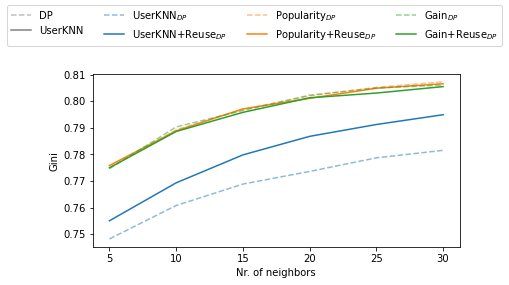

In [20]:
%matplotlib inline
fig = plt.figure()
#plt.plot(K, gini_no, color="gray", linestyle="solid", alpha=0.75)
#plt.plot(K, gini_full, color="gray", linestyle="dashed", alpha=0.75)
plt.plot(K, gini_userknn, color="C0", linestyle="dashed", alpha=0.5)
plt.plot(K, gini_userknnreuse, color="C0")
plt.plot(K, gini_pop, color="C1", linestyle="dashed", alpha=0.5)
plt.plot(K, gini_popreuse, color="C1")
plt.plot(K, gini_gain, color="C2", linestyle="dashed", alpha=0.5)
plt.plot(K, gini_gainreuse, color="C2")
plt.ylabel("Gini")
plt.xlabel("Nr. of neighbors")

colors = ['gray', 'C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["DP", "UserKNN", r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=4, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

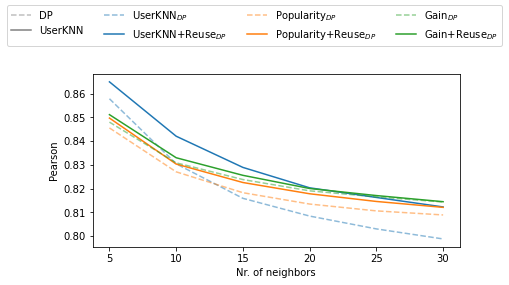

In [21]:
%matplotlib inline
fig = plt.figure()
#plt.plot(K, corr_no, color="gray", linestyle="solid", alpha=0.75)
#plt.plot(K, corr_full, color="gray", linestyle="dashed", alpha=0.75)
plt.plot(K, corr_userknn, color="C0", linestyle="dashed", alpha=0.5)
plt.plot(K, corr_userknnreuse, color="C0")
plt.plot(K, corr_pop, color="C1", linestyle="dashed", alpha=0.5)
plt.plot(K, corr_popreuse, color="C1")
plt.plot(K, corr_gain, color="C2", linestyle="dashed", alpha=0.5)
plt.plot(K, corr_gainreuse, color="C2")
plt.ylabel("Pearson")
plt.xlabel("Nr. of neighbors")

colors = ['gray', 'C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["DP", "UserKNN", r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=4, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

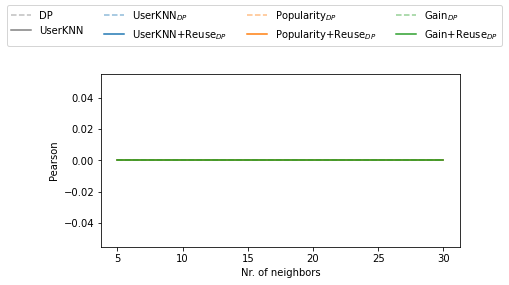

In [22]:
%matplotlib inline
fig = plt.figure()
#plt.plot(K, corr_no, color="gray", linestyle="solid", alpha=0.75)
#plt.plot(K, corr_full, color="gray", linestyle="dashed", alpha=0.75)
plt.plot(K, p_userknn, color="C0", linestyle="dashed", alpha=0.5)
plt.plot(K, p_userknnreuse, color="C0")
plt.plot(K, p_pop, color="C1", linestyle="dashed", alpha=0.5)
plt.plot(K, p_popreuse, color="C1")
plt.plot(K, p_gain, color="C2", linestyle="dashed", alpha=0.5)
plt.plot(K, p_gainreuse, color="C2")
plt.ylabel("Pearson")
plt.xlabel("Nr. of neighbors")

colors = ['gray', 'C0', 'C1', 'C2']
lines = []
labels = []
for c in colors:
    lines.append(Line2D([0], [0], color=c, linestyle='dashed', alpha=0.5))
    lines.append(Line2D([0], [0], color=c, linestyle="solid"))
labels = ["DP", "UserKNN", r"UserKNN$_{DP}$", r"UserKNN+Reuse$_{DP}$", r"Popularity$_{DP}$", r"Popularity+Reuse$_{DP}$", r"Gain$_{DP}$", r"Gain+Reuse$_{DP}$"]

fig.legend(lines, labels, ncol=4, loc='upper center')
fig.tight_layout()
fig.subplots_adjust(top=.75, bottom=0.15, hspace=0.35, wspace=0.35)

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

def mann_whitney_u_test(x, y, alternative="less"):
    u, p = mannwhitneyu(x, y, alternative=alternative)
    nx = len(x)
    ny = len(y)
    mu_u = (nx * ny) / 2
    sigma_u = np.sqrt(nx * ny * (nx + ny + 1) / 12)
    z = (u - mu_u) / sigma_u
    n = len(x) + len(y)
    r = z / np.sqrt(n)
    return u, p, r

ttest_ind(corr_userknn, corr_gain), mann_whitney_u_test(corr_userknn, corr_gain, alternative="two-sided")